# CS-E4740 Federated Learning 
# Coding Assignment for Quiz "Graph Learning"
## A. Jung, April 2023


# Rationale

The code snippet below reads in an empirical graph from the file `QuizGraphLearning.pickle` which you can find on my GitHub (in the same folder as this notebook!). The empirical graph is stored in a `networkx.Graph` whose nodes carry local datasets as node attributes. The code snippets below provide implementations of a graph learning method based on simple statistical parameters of each local dataset. In particular, we will use the sample averages of feature and label values of data points in a local dataset. We then use these averages (two for each node) to learn a nearest neighbour graph with edge weights determined by the Euclidean distance between the averages at the connected nodes (see Section 7.5.1 of lecture notes https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FL_LectureNotes.pdf)

Your task is to investigate the effect of using different parameter values for the graph learning method, such as 

* the number of neighbours `nrneighbors` connected to each node of the empirical graph (see parameter `nrneighbors`of function `AddEdges` 
* the reference distance used to compute the edge weights (see parameter `refdistance`of function `AddEdges`

The choices for these above hyper-parameters determine the resulting hypothesis maps learnt by the function `FedRelaxDT` which we have already implemented below. This function implements a special case of Algorithm 4 in the lecture notes https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FL_LectureNotes.pdf. You are also to investigate the effect of different choices for 
* the regularization parameter `regparam` (which is the $\lambda$ in the objective function of GTVMin) of the function `FedRelaxDT`
* the test set `Xtest` used to compute the discrepancy of hypothesis maps at connected nodes (see Algorithm 4 in lecture notes) 

One principled approach to diagnose the hypothesis maps learnt by a ML method such as `FedRelaxDT` is to compute and compare training and validation errors. Note that each node in the empirical graph carries its own local training set and validation set. In this exercise, we use squared error loss to compute training and validation  errors for each node and their average (over all nodes in the empirical graph). Your task is to investigate how training and validation errors vary with different choices for the above graph learning paramters `nrneighbors` and `refdistance` as well as the regularization parameter `regparam`. 

each node has attributes: 
Xval  numpy array of shape  (400, 1)
yval  numpy array of shape  (400, 1)
Xtrain  numpy array of shape  (40, 1)
ytrain  numpy array of shape  (40, 1)


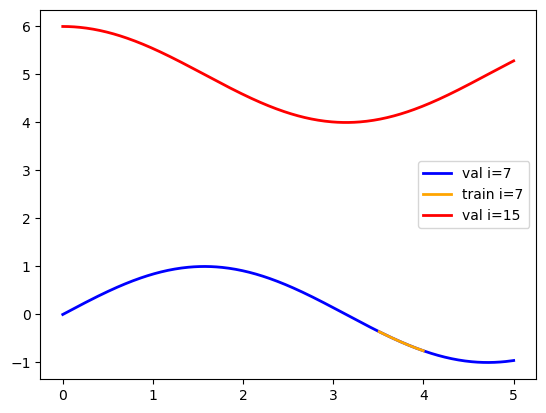

In [34]:
# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import networkx as nx 
import pickle


# load graph object from file
G = pickle.load(open('QuizGraphLearning.pickle', 'rb'))

print("each node has attributes: ")
for attribute_name in G.nodes[0].keys(): 
    print(attribute_name, " numpy array of shape ",G.nodes[0][attribute_name].shape)
    
# plot validation sets and training sets at two nodes 7 and 15 

plt.plot(G.nodes[7]["Xval"], G.nodes[7]["yval"], color="blue", label="val i=7", linewidth=2)
plt.plot(G.nodes[7]["Xtrain"], G.nodes[7]["ytrain"], color="orange", label="train i=7", linewidth=2)
plt.plot(G.nodes[15]["Xval"], G.nodes[11]["yval"], color="red", label="val i=15", linewidth=2)

plt.legend()
    

The code snippet below computes two new features $z^{(i,1)},z^{(i,2)}$ for each local dataset $D^{(i)}$ with $i \in \{1,2,\ldots\}$. These two features are the sample averages of the features $x^{(i,1)}, x^{(i,2)}, \ldots $ and labels $y^{(i,1)},y^{(i,2)},\ldots$ of the data points in $D^{(i)}$. We store the new features $z^{(i,1)},z^{(i,2)}$ as a numpy array in the node attribute "coords". 

In [35]:
for iter_node in G.nodes(): 
    nodefeatures = np.array([np.mean(G.nodes[iter_node]["Xtrain"]),np.mean(G.nodes[iter_node]["ytrain"])])
    G.nodes[iter_node]['coords'] = nodefeatures 
    G.nodes[iter_node]["name"] = str(iter_node)

print(G.nodes[0]['coords'])

[0.2443609  0.23941295]


The code snippet below defines a function `PlotGraph` that reads in a networkx graph `graphin`. The parameter `pos` is the name of the node attribute (being a numpy array) that will be used as coordinates of node markers. The paramete `annotate` holds the name of the node attribute that is used to annotate the markers. 

In [36]:
def PlotGraph(graphin,pos='coord',annotate="name"): 
    
    # the numpy array x will hold the horizontal coord of markers for each node in emp. graph graphin
    x = np.zeros(len(graphin.nodes))
    # vertical coords of markers 
    y = np.zeros(len(graphin.nodes))
    
    for iter_node in graphin.nodes:
        x[iter_node]= graphin.nodes[iter_node][pos][0] 
        y[iter_node]= graphin.nodes[iter_node][pos][1]

    # standareize the coordinates of node markers 
    
    x = (x - np.min(x, axis=0))/np.std(x, axis=0) + 1 
    y = (y - np.min(y, axis=0))/np.std(y, axis=0) + 1 

    # create a figure with prescribed dimensions 
    fig, ax = plt.subplots(figsize=(10,10))
    
    # generate a scatter plot with each marker representing a node in graphin
    ax.scatter(x, y, 300, marker='o', color='Black')

# draw links between two nodes if they are connected by an edge 
# in the empirical graph. use the "weight" of the edge to determine the line thickness
    for edge_dmy in graphin.edges:
        ax.plot([x[edge_dmy[0]],x[edge_dmy[1]]],[y[edge_dmy[0]],y[edge_dmy[1]]],c='black',lw=4*graphin.edges[edge_dmy]["weight"])

    # annotate each marker by the node attribute whose name is stored in the input parameter "annotate"
    for iter_node in graphin.nodes : 
        ax.annotate(str(graphin.nodes[iter_node][annotate]),(x[iter_node]+0.2, 0.995*y[iter_node]),c="red" )
    ax.set_ylim(0.9*np.min(y),1.1*np.max(y))
    ax.set_xlim(0.9*np.min(x),1.1*np.max(x))
    plt.show

In [37]:
from sklearn.neighbors import kneighbors_graph
from numpy import linalg as LA

def AddEdges(graphin,nrneighbors=3,pos='coord',refdistance=1): 
    edges = graphin.edges()
    graphin.remove_edges_from(edges)
    
    # build up a numpy array tmp_data which has one row for each node in graphin
    tmp_data = np.zeros((len(graphin.nodes()),len(graphin.nodes[0][pos])))
    for iter_node in graphin.nodes(): 
        # each row of tmp_data holds the numpy array stored in the node attribute selected by parameter "pos" 
        tmp_data[iter_node,:] = graphin.nodes[iter_node][pos]
        
    A = kneighbors_graph(tmp_data, nrneighbors, mode='connectivity', include_self=False)
    A.toarray()
    for iter_i in range(len(graphin.nodes)): 
        for iter_j in range(len(graphin.nodes)): 
            # add an edge between nodes i,j if entry A_i,j is non-zero 
            if A[iter_i,iter_j] > 0 : 
                graphin.add_edge(iter_i, iter_j)
                # use the Euclidean distance between node attribute selected by parameter "pos" 
                # to compute the edge weight 
                graphin.edges[(iter_i,iter_j)]["weight"] = np.exp(-LA.norm(tmp_data[iter_i,:]-tmp_data[iter_j,:],2)/refdistance)

The code snippet below defines a function `FedRelaxDT` that implements Algorithm 4 in https://github.com/alexjungaalto/FederatedLearning/blob/main/material/FL_LectureNotes.pdf for the specific choice of `DecisionTreeRegressor(max_depth=4)` as local model at each node of the empirical graph stored in `QuizGraphLearning.pickle`. 

In [38]:
def FedRelaxDT(Gin,Xtest,regparam=0,maxiter=100):
    
    # determine the number of data points in test set 
    
    testsize = Xtest.shape[0]
    
    # attach a DecitionTreeRegressor as local model to each node in Gin
    for node_i in Gin.nodes(data=False): 
        Gin.nodes[node_i]["model"] = DecisionTreeRegressor(max_depth=4).fit(G.nodes[node_i]["Xtrain"],G.nodes[node_i]["ytrain"])
    
    # repeat the local updates (simultaneously at all nodes) for maxiter iterations 
    for iter_GD in range(maxiter):
    # the following "for loop" 
        for node_i in Gin.nodes(data=False):
            # build up augmented dataset for the local update 
            tmp_y = G.nodes[node_i]["ytrain"].reshape(-1,1)
            tmp_X = G.nodes[node_i]["Xtrain"]
            localsamplesize = len(tmp_y)
            
            # this is the sample weight used for augmented data points (see Algorithm 4 in Lecture notes)
            sampleweightaug = (regparam*localsamplesize/testsize)
            # build up a numpy array whose entris are the sample weights for the augmented dataset 
            sample_weight = np.ones((localsamplesize,1))
            
            # loop over all neighbours of i 
            for node_j in G[node_i]:
                # for each neighbour j augment local dataset at node i by a new
                # dataset obtained from the features of the test set 
                # add the feature vectors of local dataset at node j 
                tmp_X = np.vstack((tmp_X,Xtest))   #G.nodes[node_j]["Xtrain"]))               
                # add the predictions of current hypothesis at node j as labels 
                neighbourpred=G.nodes[node_j]["model"].predict(Xtest).reshape(-1,1)
                tmp_y = np.vstack((tmp_y,neighbourpred))
                # set sample weights of added local dataset according to edge weight of edge i <-> j 
                # and GTV regularization parameter 
                sample_weight = np.vstack((sample_weight,sampleweightaug*G.edges[(node_i,node_j)]["weight"]*np.ones((len(neighbourpred),1))))  
            G.nodes[node_i]["model"].fit(tmp_X,tmp_y,sample_weight.reshape(-1))

[4.7556391  5.04278569]
runtime of FedRelaxDT  0.8893270492553711
average train error : 0.0003469541884166122
average val error : 0.5059296798186895


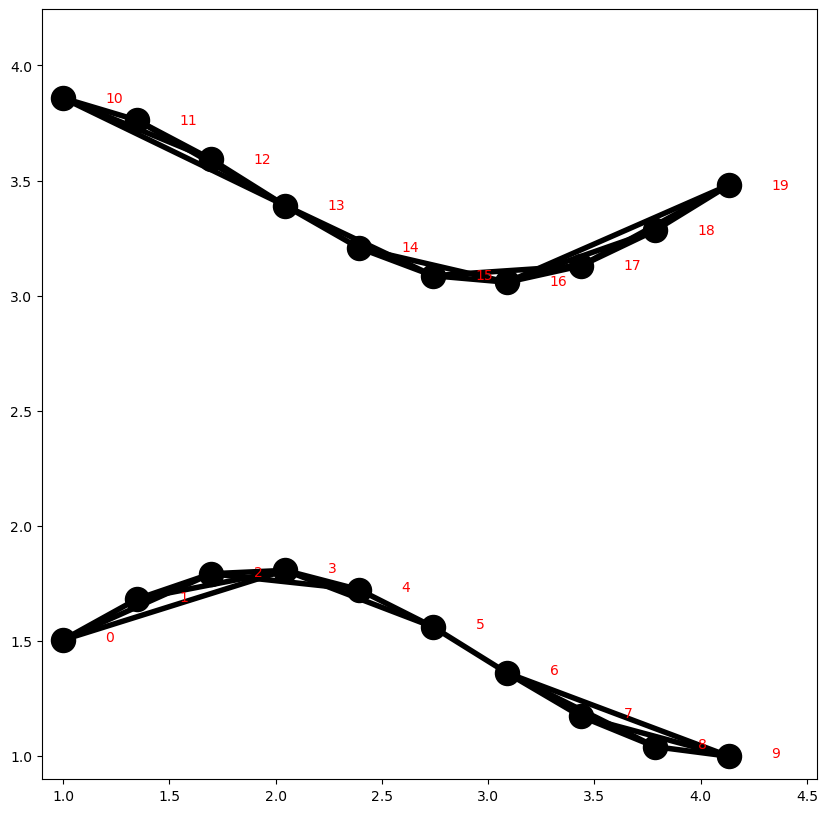

In [39]:
import time
from sklearn.metrics import mean_squared_error

AddEdges(G,nrneighbors=3,pos='coords',refdistance=100)

print(G.nodes[iter_node]['coords'])

PlotGraph(G,pos='coords',annotate='name')

# generate global test_set
X_test = np.arange(0.0, 1, 0.1)[:, np.newaxis]
# get the start time
st = time.time()
FedRelaxDT(G,X_test,0.1,100)
end = time.time()
print("runtime of FedRelaxDT ",end-st)

# compute node-wise train and val errors 

for iter_node in G.nodes(): 
    trainedlocalmodel = G.nodes[iter_node]["model"]
    trainfeatures = G.nodes[iter_node]["Xtrain"]
    trainlabels=G.nodes[iter_node]["ytrain"]
    G.nodes[iter_node]["trainerr"] = mean_squared_error(trainlabels,trainedlocalmodel.predict(trainfeatures))
    valfeatures = G.nodes[iter_node]["Xval"]
    vallabels=G.nodes[iter_node]["yval"]
    G.nodes[iter_node]["valerr"] = mean_squared_error(vallabels,trainedlocalmodel.predict(valfeatures))
    
   
print("average train error :",sum(nx.get_node_attributes(G, "trainerr").values())/len(G.nodes()))
print("average val error :",sum(nx.get_node_attributes(G, "valerr").values())/len(G.nodes()))
#print(nx.get_node_attributes(G, "trainerr"))
#print(nx.get_node_attributes(G,"valerr"))

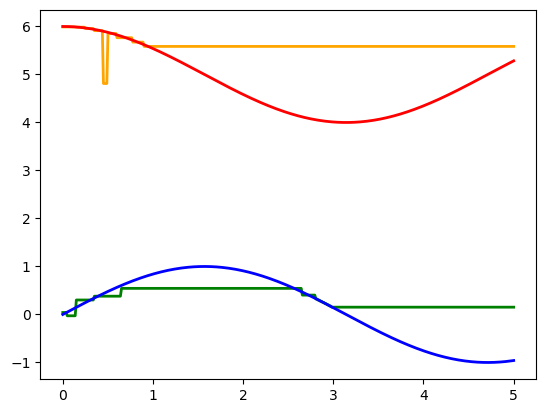

In [40]:
X_val = G.nodes[0]["Xval"]
y_1 = G.nodes[11]["model"].predict(X_val)
y_2 = G.nodes[5]["model"].predict(X_val)
# Plot the results
plt.figure()
plt.plot(X_val, y_1, color="orange", label="validation data cluster 0", linewidth=2)
plt.plot(X_val, y_2, color="green", label="validation data cluster 0", linewidth=2)
plt.plot(G.nodes[7]["Xval"], G.nodes[0]["yval"], color="blue", label="validation data cluster 0", linewidth=2)
plt.plot(G.nodes[15]["Xval"], G.nodes[11]["yval"], color="red", label="val data second cluster", linewidth=2)

In [ ]:
### Student Task ####
# explore the effect of increasing/decreasing parameters "nrneighbors", "refdistance" 
# in function "AddEdges" and the parameters "regparam", "Xtest" in function "FedRelaxDT"

